# Redes neuronales convolucionales

Una red neuronal convolucional (CNN por sus siglas en inglés, Convolutional Neural Network) es un tipo de red neuronal artificial especialmente diseñada para procesar datos que tienen una estructura de cuadrícula, como imágenes. Está inspirada en el funcionamiento del sistema visual biológico y es muy efectiva en tareas de reconocimiento visual y clasificación de imágenes.

Lo que hace única a una CNN es su capacidad para detectar patrones locales en datos de entrada utilizando filtros convolucionales. Estos filtros son pequeñas matrices numéricas que se deslizan sobre la imagen de entrada para realizar operaciones de convolución. Esta operación de convolución permite a la red extraer características relevantes de la imagen, como bordes, texturas o formas.

En este notebook implementaremos una capa convolucional usando python y numpy. Pondremos énfasis en la implementación de la convolución a partir de los hiper-parámetros de la capa convolucional. En particular usaremos la variante de correlación cruzada que se define de la siguiente forma:

$$
	G[i,j] =  \sum_{u=-k}^{k} \sum_{v=-k}^{k} H[u,v] I[i+u,j+v]
$$
donde $I$ es la ntrada y $H$ el kernel.

Visualmente tendríamos algo similar a la siguiente figura. Donde la imagen original esta en azul y la imagen resultante está en verde.

<img src="same_padding_no_strides_00.png">

Como entrada usaremos una imagen popular en visión computacional, Lenna. Y, si todo sale bien, la salida deberá realizar la detección de bordes verticales.

<img src="Lenna.png">

In [13]:
# Paquetes
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

Dimensiones de la imagen: (256, 256)
Tipo de datos de la matriz: uint8
Matriz de la imagen:
[[226 223 226 ... 230 232 211]
 [226 223 226 ... 230 232 211]
 [226 224 226 ... 221 216 185]
 ...
 [ 90  92  97 ... 140 158 162]
 [ 86  92  95 ... 154 171 171]
 [ 83  94  95 ... 167 178 183]]


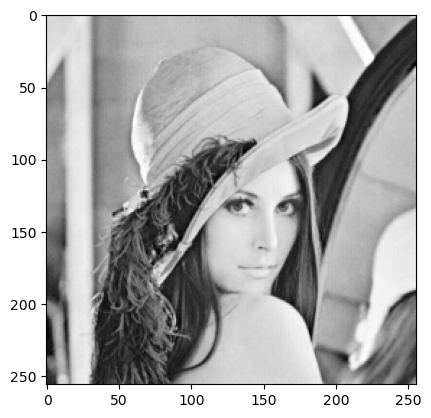

In [14]:
# Ruta de la imagen
ruta_imagen = "Lenna.png"

# Abrir la imagen con PIL
imagen_pil = Image.open(ruta_imagen)

# Convertir la imagen a una matriz de NumPy
imagen_numpy = np.array(imagen_pil)
array_transposed = imagen_numpy.transpose((2, 0, 1))
red_channel = array_transposed[0]

# Mostrar información sobre la matriz de la imagen
print("Dimensiones de la imagen:", red_channel.shape)
print("Tipo de datos de la matriz:", red_channel.dtype)

# Mostrar la matriz de la imagen (opcional)
print("Matriz de la imagen:")
print(red_channel)

plt.imshow(red_channel, cmap='gray')

## Implementación del kernel

El kernel ($H$) es una matriz cuadrada cuyas dimensiones son $(2k+1) \times (2k+1)$, donde $k$ es un número entero positivo. Al utilizar el parámetro $k$ aseguramos que el kernel tenga tamaño impar. Los elementos de $k$ pueden tener valores arbitrarios de acuerdo al efecto que deseemos (los veremos más tarde). Por ahora, diremos que es deseable que la sumatoria de sus elementos sea igual a 1, si la sumatoria no es igual a 1 la imagen de salida será escalada. 

En este ejemplo, supondremos que $k=1$ y que los elementos de $H$ simulan un filtro detector de bordes verticales. 

[[-0.33333334  0.          0.33333334]
 [-0.33333334  0.          0.33333334]
 [-0.33333334  0.          0.33333334]]


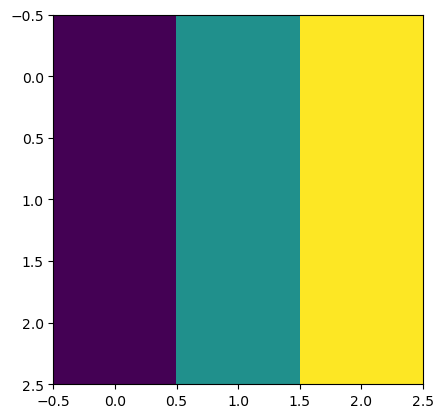

In [15]:
# Definir kernel (filtro)
k = 1
tamano = 2 * k + 1
kernel = np.zeros((tamano, tamano), np.float32) / (tamano**2)
kernel[0][0] = -1.0/3
kernel[1][0] = -1.0/3
kernel[2][0] = -1.0/3

kernel[0][2] = 1.0/3
kernel[1][2] = 1.0/3
kernel[2][2] = 1.0/3

# imprimir el filtro
print(kernel)
plt.imshow(kernel)
plt.show()

## Implementar correlación-cruzada

Recordando que:

$$
	G[i,j] =  \sum_{u=-k}^{k} \sum_{v=-k}^{k} H[u,v] I[i+u,j+v]
$$
donde $I$ es la imagen de entrada y $H$ el kernel.

### Padding

En este ejemplo usaremos padding p=0. Esto significa que no se agregan capas al rededor de la imagen de entrada.

![](same_padding_no_strides_00.png)

In [16]:
def correlacionPixel(H, I, i, j):
    m, n = I.shape
    doskmas1, _ = H.shape  
    k = (doskmas1 - 1) // 2 
    sumatoria = 0

    for u in range(-k, k + 1):
        for v in range(-k, k + 1):
            if 0 <= i + u < m and 0 <= j + v < n:
                sumatoria += H[k + u, k + v] * I[i + u, j + v]

    return int(sumatoria)

def correlacionCruzada(H, I):
    doskmas1, _ = H.shape
    k = (doskmas1 - 1) // 2 
    m, n = I.shape

    G = np.zeros((m, n), dtype=int)
    for i in range(k, m - k):
        for j in range(k, n - k):
            G[i, j] = correlacionPixel(H, I, i, j)

    return G


In [17]:
correlacionPixel(H = kernel, I = red_channel, i=1, j=1)

0

## Prueba

Ahora haremos la convolución sobre nuestra imagen de entrada. Además, aunque no es muy común en las redes, En algunos casos se puede aplicar una función de activación. Solo para propósitos de prueba, pasaremos el resultado por una función relu. Si todo va bien debes obtener al final una imagen como esta:

<img src="ccnout.png">

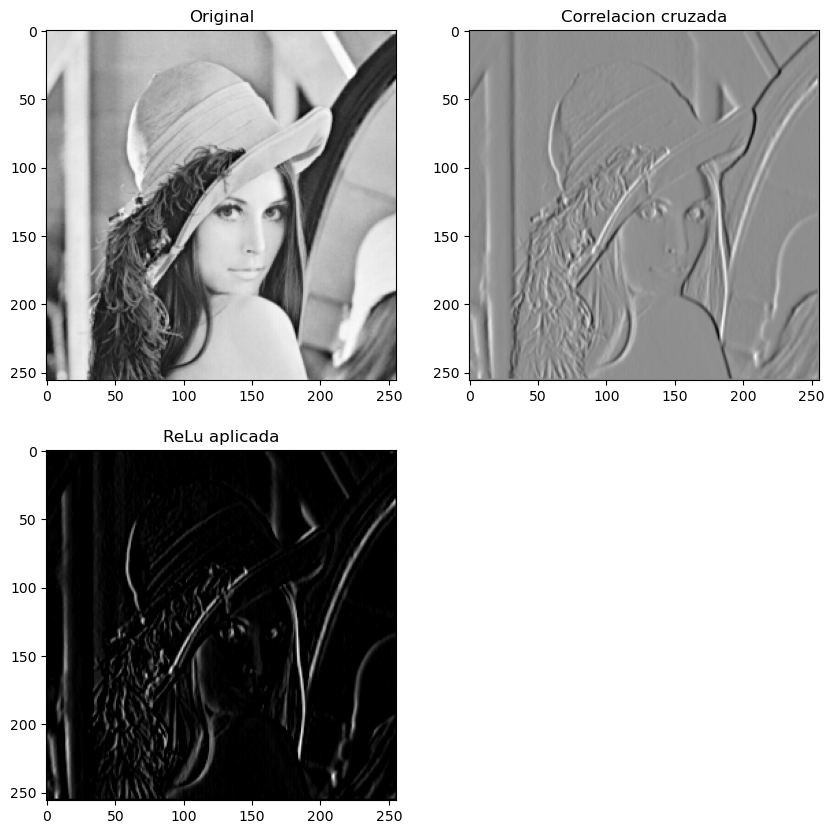

In [18]:
#aplicar la correlación cruzada
resultado = correlacionCruzada(H = kernel, I = red_channel)
relu_activated = np.maximum(0, resultado)

plt.figure(figsize=(10, 10))

plt.subplot(221)
plt.imshow(red_channel, cmap = 'gray')
plt.title('Original')

plt.subplot(222)
plt.imshow(resultado, cmap = 'gray')
plt.title('Correlacion cruzada')

plt.subplot(223)
plt.imshow(relu_activated, cmap = 'gray')
plt.title('ReLu aplicada')

plt.show()

Contesta las siguientes preguntas:

## - ¿Por que en la imagen relu_activated solo se ven algunos bordes verticales y no todos?
Es debido al tipo de kernel que se utilizó para la correlación cruzada. El kernel se definió para destacar los cambios verticales de intensidad que siguen un patrón específico (como ciertas transiciones de claro a oscuro o viceversa). Además, la función ReLU elimina los valores negativos resultantes de la correlación cruzada, lo que significa que solo las características verticales que resultaron en valores positivos (generalmente bordes claros precedidos por bordes oscuros bajo ciertas condiciones de iluminación y color) serán visibles.


## - ¿Que padding debemos utilizar para evitar los contornos vacíos en la imagen de salida?
Tomando en cuenta que el padding consiste en añadir bordes adicionales alrededor de la imagen original antes de aplicar el filtro, esta operación permitiría que el filtro se aplique también en los bordes de la imagen, evitando que las dimensiones de la imagen de salida se reduzcan y que los bordes resulten incompletos. Para un filtro con un kernel de tamaño (2k+1)×(2k+1)(2k+1)×(2k+1), se suele añadir un padding de kk píxeles en todos los bordes. En nuestro caso, como el kernel parece tener un tamaño de 3x3 (k=1), debemos añadir un padding de 1 píxel en cada borde.

Ve más alla, puedes incluir max pooling?

In [19]:
import numpy as np

def max_pooling(image, pool_size=2, stride=2):
    n_rows, n_cols = image.shape
    output_rows = (n_rows - pool_size) // stride + 1
    output_cols = (n_cols - pool_size) // stride + 1

    pooled_image = np.zeros((output_rows, output_cols))

    for i in range(output_rows):
        for j in range(output_cols):
            r_start = i * stride
            c_start = j * stride
            r_end = r_start + pool_size
            c_end = c_start + pool_size
            
            pooled_image[i, j] = np.max(image[r_start:r_end, c_start:c_end])
    
    return pooled_image

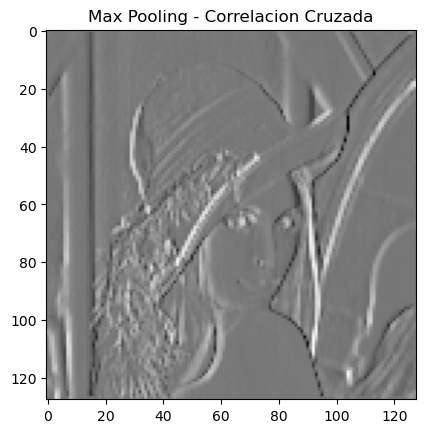

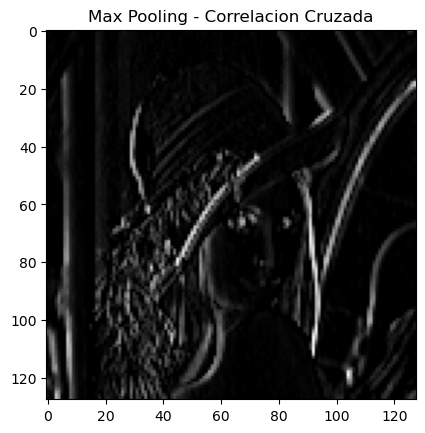

In [20]:
pooled_image = max_pooling(resultado, pool_size=2, stride=2)

plt.imshow(pooled_image, cmap='gray')
plt.title('Max Pooling - Correlacion Cruzada')
plt.show()

relu_activated = np.maximum(0, resultado)
pooled_image = max_pooling(relu_activated, pool_size=2, stride=2)

plt.imshow(pooled_image, cmap='gray')
plt.title('Max Pooling - Correlacion Cruzada con ReLU')
plt.show()


## Conclusiones

En esta práctica, exploramos el procesamiento de imágenes utilizando técnicas fundamentales de redes neuronales convolucionales, enfocándonos en operaciones específicas como la correlación cruzada, la aplicación de la función de activación ReLU, y la técnica de max pooling. Utilizando una imagen estándar como entrada, implementamos un kernel de filtrado diseñado para resaltar características verticales específicas.

La inclusión de la operación de max pooling demostró ser crucial para reducir la dimensionalidad de la imagen mientras se preservan las características más importantes detectadas por el filtro. Esta operación también contribuye a la robustez del modelo frente a pequeñas variaciones y ruido en la imagen de entrada.

Los resultados visuales obtenidos nos permitieron observar directamente el impacto de cada operación, facilitando una comprensión más profunda de cómo las capas convolucionales procesan y transforman los datos de entrada en un contexto de aprendizaje de características. Esta práctica subraya la importancia de las técnicas convolucionales en el procesamiento avanzado de imágenes y proporciona una base sólida para explorar arquitecturas de CNN más complejas y sus aplicaciones en problemas reales de visión por computadora.